In [1]:
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import boxcox, chi2_contingency
from scipy.special import inv_boxcox

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import pickle

from common.utils import *

pd.options.display.max_rows = 200

In [3]:
train_data = pd.read_csv('../data/Crop_Data__train.csv')

In [4]:
df = train_data.copy()

In [5]:
# Track columns which need to be dropped
cols_to_drop = []

# Yield = Boxcox(Yield)

In [6]:
df, lmda = convert_to_yield(df, to_boxcox=True)

In [7]:
df.head()

,State,District,Lat,Long,GW_depth_Min,GW_depth_Max,Wells_depth_0_to_2,Wells_depth_2_to_5,Wells_depth_5_to_10,Wells_depth_10_to_20,...,Temp_Max,Temp_Min,Dew_Frost_Point,Wind_Speed,Year,Season,Crop,Area,Production,Yield
0,CHHATTISGARH,KANKER,20.11602,80.75973,1.50,9.50,1,1,4,0.0,...,30.652,15.924,10.428,1.364,2007,Rabi,Moong(Green Gram),93.00,31.0,0.255543
1,KARNATAKA,SHIMOGA,14.54387,76.23089,1.30,18.05,4,11,21,35.0,...,31.448,19.958,16.594,3.268,2014,Whole Year,Cardamom,400.00,54.0,0.120126
2,MADHYA PRADESH,ALIRAJPUR,23.64296,78.09823,5.70,11.70,0,0,9,4.0,...,32.204,23.580,21.370,2.116,2010,Kharif,Castor seed,542.00,235.0,0.310765
3,UTTAR PRADESH,AURAIYA,26.65678,79.50551,4.02,22.02,0,1,7,0.0,...,34.938,25.942,21.224,1.810,2003,Kharif,Jowar,1933.00,2491.0,0.596522
4,JHARKHAND,CHATRA,24.10671,84.86166,5.10,15.75,0,0,3,5.0,...,29.652,13.434,3.322,1.726,2006,Rabi,Gram,167.93,157.0,0.506604


In [8]:
print(f"Boxcox lambda - {lmda}")

Boxcox lambda - -0.8405159859909147


## Drop Production and Area

In [9]:
df = df.drop(['Production', 'Area'], axis=1)

# Categorical Columns

## Lat and Long

We must consider Lat and Long as categorical features to avoid any bias in prediction value. This is because numerical values of latitide and longitude do not quantify the production of crop but only provide information of geographical location.

In [10]:
df[['Lat', 'Long']].nunique()

Lat     459
Long    459
dtype: int64

**Pipeline Action**

Based on cluster analysis and EDA we can seggregate Lat and Long values into six regions.

In [11]:
with open('../Analysis_and_Data_Processing/latlong_custerer_6.pkl', 'rb') as f:
    lat_long_clusterer = pickle.load(f)

In [12]:
df = identify_geo_region(df, lat_long_clusterer)

In [13]:
df['Geo_Region'].value_counts().sort_index()

R0    27607
R1    33775
R2    14884
R3    36546
R4    20667
R5    31073
Name: Geo_Region, dtype: int64

In [14]:
df = df.drop(['Lat', 'Long'], axis=1)

In [15]:
cols_to_drop.append('Lat')
cols_to_drop.append('Long')

## State and District

In [16]:
df['State'].nunique()

30

In [17]:
df['District'].nunique()

516

**Pipeline Action**

We can drop State and District columns as they are well represented by Geo_Region clusters.

Also being categorical input with many unique values, State and District would increase the feature set a lot.

In [18]:
df = df.drop(['State', 'District'], axis=1)

cols_to_drop.append('State')
cols_to_drop.append('District')

## Geo_Region

In [19]:
df['Geo_Region'].value_counts()

R3    36546
R1    33775
R5    31073
R0    27607
R4    20667
R2    14884
Name: Geo_Region, dtype: int64

<AxesSubplot:xlabel='Geo_Region', ylabel='Yield'>

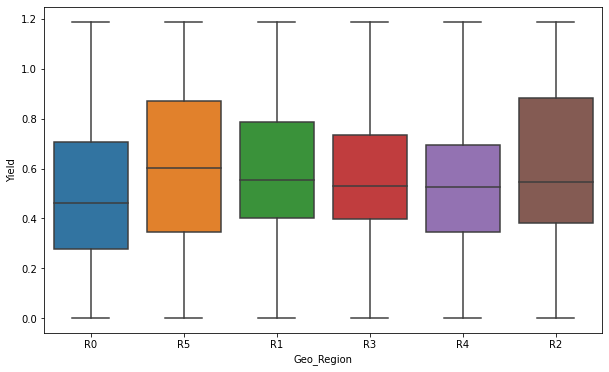

In [20]:
plt.figure(figsize=(10,6))
sns.boxplot(y='Yield', x='Geo_Region', data=df)

In [21]:
# ANOVA test with Yield
anova_result = smf.ols(formula='Yield ~ C(Geo_Region)', data=df).fit()
anova_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Yield   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     567.6
Date:                Sun, 14 Mar 2021   Prob (F-statistic):               0.00
Time:                        13:21:26   Log-Likelihood:                -26942.
No. Observations:              164552   AIC:                         5.390e+04
Df Residuals:                  164546   BIC:                         5.396e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.5171      0.002    301.451      0.000       0.514       0.520
C(Geo_Region)[T.R1]     0.0787      0.002     34.044      0.000       0.074       0.083
C(Geo_Region)[T.R2]     0.1091      0.003     37.635      0.000       0.103       0.115
C(Geo_Region)[T.R3]     0.0653      0.002     28.733      0.000       0.061       0.070
C(Geo_Region)[T.R4]     0.0220      0.003      8.397      0.000       0.017       0.027
C(Geo_Region)[T.R5]     0.1015      0.002     43.072      0.000       0.097       0.106
==============================================================================
Omnibus:                    10814.386   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6621.855
Skew:                           0.360   Prob(JB):                         0.00
Kurtosis:                       2.332   Cond. No.                         6.95
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Season

In [22]:
df['Season'].value_counts()

Kharif        63254
Rabi          44303
Whole Year    38602
Summer        10840
Winter         4200
Autumn         3353
Name: Season, dtype: int64

<AxesSubplot:xlabel='Season', ylabel='Yield'>

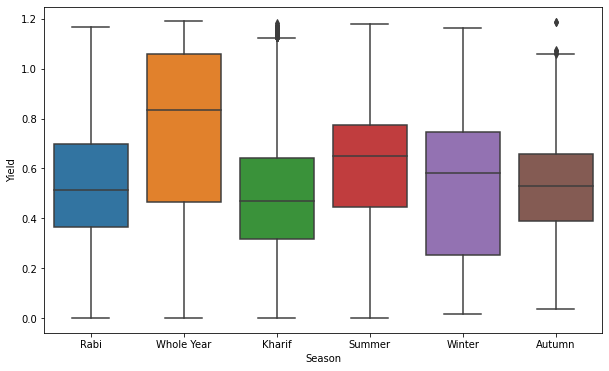

In [23]:
plt.figure(figsize=(10,6))
sns.boxplot(y='Yield', x='Season', data=df)

In [24]:
# ANOVA test with Yield
anova_result = smf.ols(formula='Yield ~ C(Season)', data=df).fit()
anova_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Yield   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     4654.
Date:                Sun, 14 Mar 2021   Prob (F-statistic):               0.00
Time:                        13:21:28   Log-Likelihood:                -17465.
No. Observations:              164552   AIC:                         3.494e+04
Df Residuals:                  164546   BIC:                         3.500e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.5165      0.005    111.148      0.000       0.507       0.526
C(Season)[T.Kharif]        -0.0190      0.005     -3.978      0.000      -0.028      -0.010
C(Season)[T.Rabi]           0.0254      0.005      5.273      0.000       0.016       0.035
C(Season)[T.Summer]         0.1077      0.005     20.248      0.000       0.097       0.118
C(Season)[T.Whole Year]     0.2364      0.005     48.789      0.000       0.227       0.246
C(Season)[T.Winter]         0.0398      0.006      6.385      0.000       0.028       0.052
==============================================================================
Omnibus:                     1366.822   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              918.525
Skew:                           0.036   Prob(JB):                    3.51e-200
Kurtosis:                       2.641   Cond. No.                         19.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Crop

In [25]:
df['Crop'].nunique()

83

In [26]:
# ANOVA test with Yield
anova_result = smf.ols(formula='Yield ~ C(Crop)', data=df).fit()
anova_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Yield   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.698
Method:                 Least Squares   F-statistic:                     4633.
Date:                Sun, 14 Mar 2021   Prob (F-statistic):               0.00
Time:                        13:21:33   Log-Likelihood:                 70135.
No. Observations:              164552   AIC:                        -1.401e+05
Df Residuals:                  164469   BIC:                        -1.393e+05
Df Model:                          82                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                0.5869      0.042     13.894      0.000       0.504       0.670
C(Crop)[T.Arecanut]                      0.0052      0.043      0.122      0.903      -0.078       0.088
C(Crop)[T.Arhar/Tur]                    -0.1516      0.042     -3.586      0.000      -0.235      -0.069
C(Crop)[T.Atcanut (Raw)]                 0.3683      0.058      6.368      0.000       0.255       0.482
C(Crop)[T.Bajra]                        -0.0571      0.042     -1.349      0.177      -0.140       0.026
C(Crop)[T.Banana]                        0.4907      0.042     11.581      0.000       0.408       0.574
C(Crop)[T.Barley]                        0.0762      0.042      1.799      0.072      -0.007       0.159
C(Crop)[T.Beans & Mutter(Vegetable)]    -0.0962      0.045     -2.144      0.032      -0.184      -0.008
C(Crop)[T.Bhindi]                       -0.1526      0.044     -3.471      0.001      -0.239      -0.066
C(Crop)[T.Black pepper]                 -0.1347      0.043     -3.157      0.002      -0.218      -0.051
C(Crop)[T.Blackgram]                    -0.1631      0.048     -3.381      0.001      -0.258      -0.069
C(Crop)[T.Brinjal]                       0.0867      0.043      2.003      0.045       0.002       0.172
C(Crop)[T.Cabbage]                      -0.0969      0.044     -2.189      0.029      -0.184      -0.010
C(Crop)[T.Cardamom]                     -0.5024      0.043    -11.591      0.000      -0.587      -0.417
C(Crop)[T.Cashewnut]                    -0.2732      0.043     -6.412      0.000      -0.357      -0.190
C(Crop)[T.Cashewnut Processed]          -0.5005      0.057     -8.775      0.000      -0.612      -0.389
C(Crop)[T.Cashewnut Raw]                -0.2520      0.051     -4.899      0.000      -0.353      -0.151
C(Crop)[T.Castor seed]                  -0.2117      0.042     -4.997      0.000      -0.295      -0.129
C(Crop)[T.Citrus Fruit]                 -0.0963      0.044     -2.208      0.027      -0.182      -0.011
C(Crop)[T.Coconut]                       0.4453      0.042     10.489      0.000       0.362       0.528
C(Crop)[T.Coffee]                       -0.1655      0.082     -2.011      0.044      -0.327      -0.004
C(Crop)[T.Colocosia]                     0.4380      0.164      2.678      0.007       0.117       0.759
C(Crop)[T.Coriander]                    -0.2632      0.042     -6.213      0.000      -0.346      -0.180
C(Crop)[T.Cotton(lint)]                 -0.0104      0.042     -0.246      0.806      -0.093       0.073
C(Crop)[T.Cowpea(Lobia)]                -0.2768      0.043     -6.440      0.000      -0.361      -0.193
C(Crop)[T.Drum Stick]                   -0.3371      0.046     -7.388      0.000      -0.426      -0.248
C(Crop)[T.Dry chillies]               

In [27]:
# Chi2 test
chi2_contingency(pd.crosstab(df['Crop'], df['Season']))

(228394.9415137103,
 0.0,
 410,
 array([[2.85271525e-01, 5.38161797e+00, 3.76927658e+00, 9.22261656e-01,
         3.28423842e+00, 3.57333852e-01],
        [2.19659074e+01, 4.14384584e+02, 2.90234297e+02, 7.10141475e+01,
         2.52886358e+02, 2.75147066e+01],
        [1.10787234e+02, 2.08998978e+03, 1.46382548e+03, 3.58166902e+02,
         1.27545745e+03, 1.38773154e+02],
        [3.26024600e-01, 6.15042054e+00, 4.30774466e+00, 1.05401332e+00,
         3.75341533e+00, 4.08381545e-01],
        [8.23212115e+01, 1.55298119e+03, 1.08770553e+03, 2.66138364e+02,
         9.47737372e+02, 1.03116340e+02],
        [4.51747837e+01, 8.52217645e+02, 5.96891870e+02, 1.46046721e+02,
         5.20082612e+02, 5.65863678e+01],
        [5.97032549e+01, 1.12629576e+03, 7.88855742e+02, 1.93016189e+02,
         6.87344183e+02, 7.47848704e+01],
        [2.22104259e+00, 4.18997399e+01, 2.93465105e+01, 7.18046575e+00,
         2.55701420e+01, 2.78209928e+00],
        [3.44363484e+00, 6.49638169e+01, 4.55005

Ideally crops are very much dependent on season. p-value of chi2 test validates this.

**X - Pipeline Action (Discarded due to loss of information in clusters of crop)**

As per custer analysis and EDA, we can reduce the feature set by clustering both Season and Crop columns as Crop_Type.

In [28]:
with open('../Analysis_and_Data_Processing/crop_season_clusterer_6.pkl', 'rb') as f:
    crop_season_clusterer = pickle.load(f)

In [29]:
df = identify_crop_types(df, crop_season_clusterer)

In [30]:
df['Crop_Type'].value_counts().sort_index()

C0    44303
C1    38602
C2    63254
C3    10840
C4     3353
C5     4200
Name: Crop_Type, dtype: int64

In [31]:
# ANOVA test with Yield
anova_result = smf.ols(formula='Yield ~ C(Crop_Type)', data=df).fit()
anova_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Yield   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     4654.
Date:                Sun, 14 Mar 2021   Prob (F-statistic):               0.00
Time:                        13:21:36   Log-Likelihood:                -17465.
No. Observations:              164552   AIC:                         3.494e+04
Df Residuals:                  164546   BIC:                         3.500e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.5419      0.001    423.898      0.000       0.539       0.544
C(Crop_Type)[T.C1]     0.2109      0.002    112.595      0.000       0.207       0.215
C(Crop_Type)[T.C2]    -0.0444      0.002    -26.625      0.000      -0.048      -0.041
C(Crop_Type)[T.C3]     0.0822      0.003     28.525      0.000       0.077       0.088
C(Crop_Type)[T.C4]    -0.0254      0.005     -5.273      0.000      -0.035      -0.016
C(Crop_Type)[T.C5]     0.0144      0.004      3.309      0.001       0.006       0.023
==============================================================================
Omnibus:                     1366.822   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              918.525
Skew:                           0.036   Prob(JB):                    3.51e-200
Kurtosis:                       2.641   Cond. No.                         8.36
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Year

**Pipeline Action**

We must drop Year column to avoid the prediction dependency on Year.

In [32]:
df = df.drop('Year', axis=1)

# Numerical Columns

## Normalize numerical features

In [33]:
for col in ['GW_depth_Min', 'GW_depth_Max', 'Wells_depth_0_to_2',
       'Wells_depth_2_to_5', 'Wells_depth_5_to_10', 'Wells_depth_10_to_20',
       'Wells_depth_20_to_40', 'Wells_depth_40_and_above', 'Precipitation',
       'Solar_Radiation', 'Surface_Pressure', 'Humidity', 'Temp_Max',
       'Temp_Min', 'Dew_Frost_Point', 'Wind_Speed']:
    df[col] = preprocessing.minmax_scale(df[col], feature_range=(1,2))

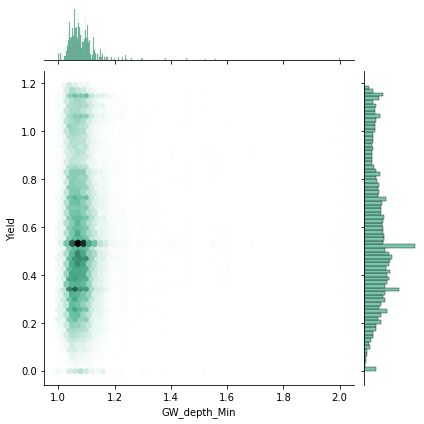

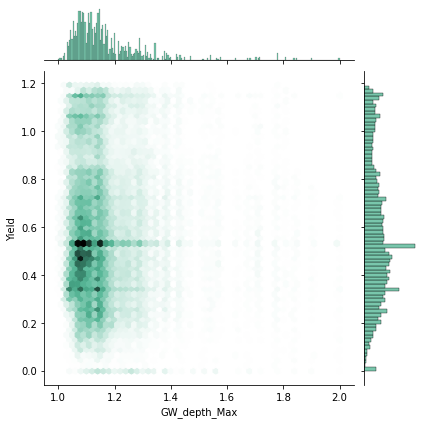

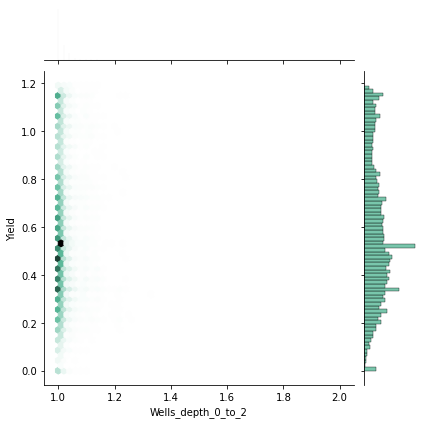

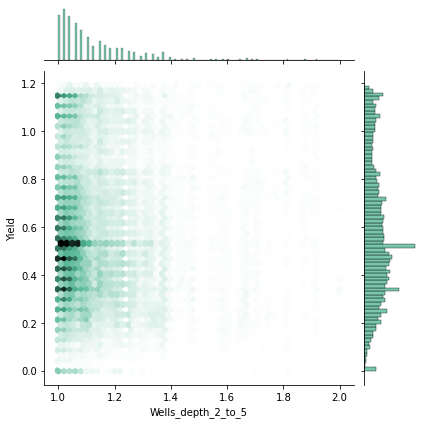

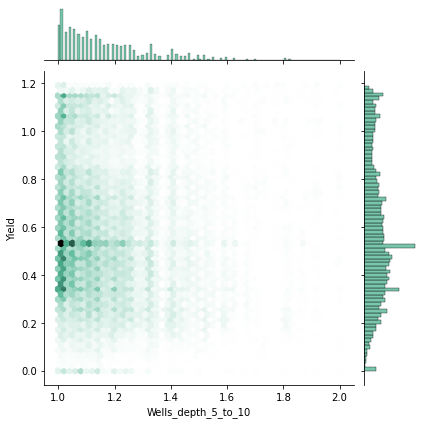

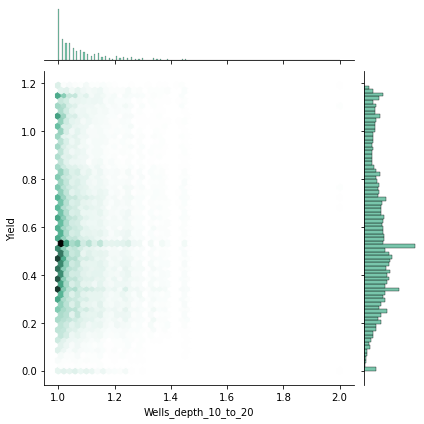

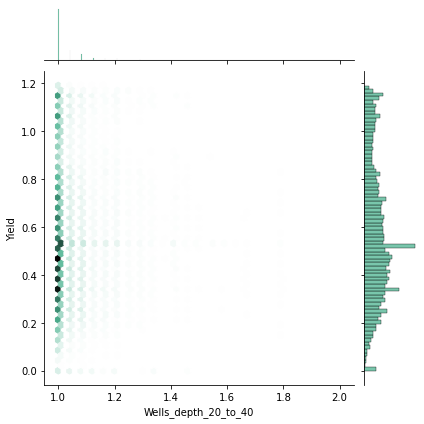

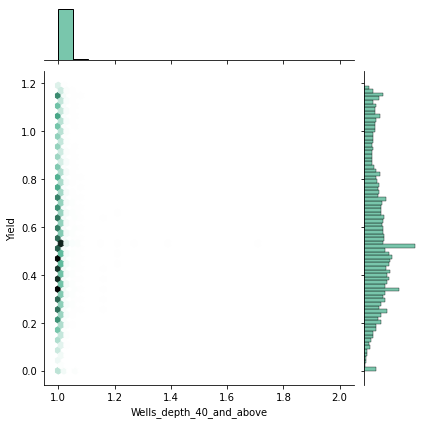

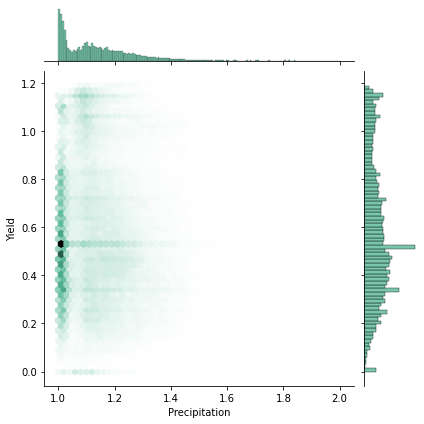

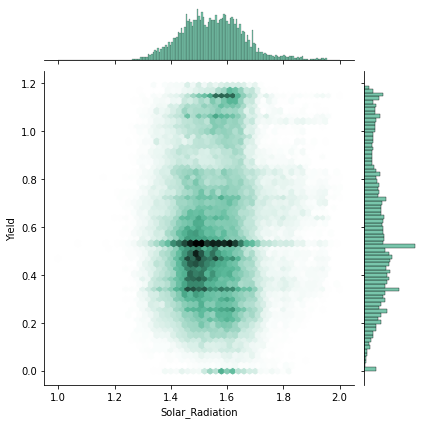

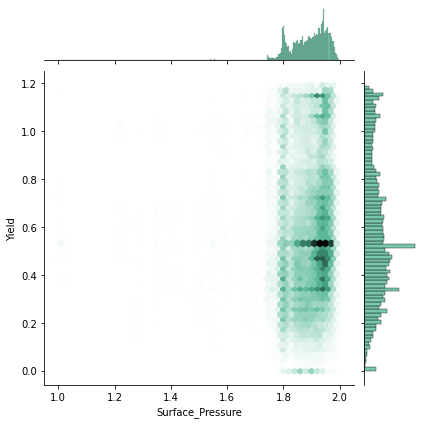

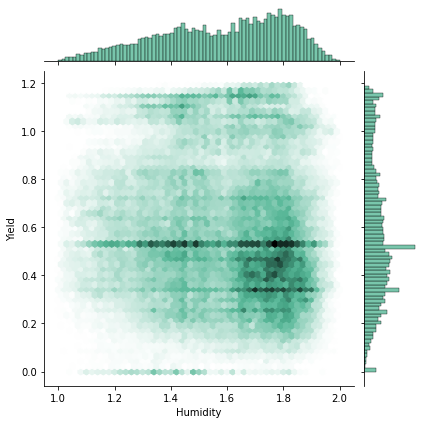

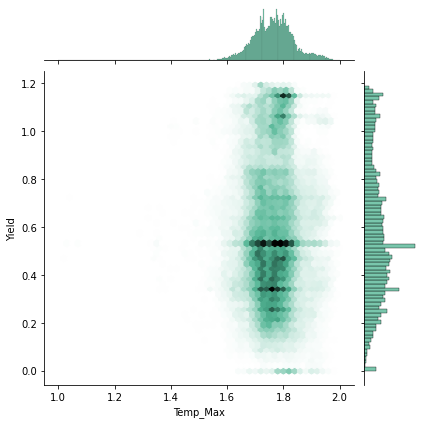

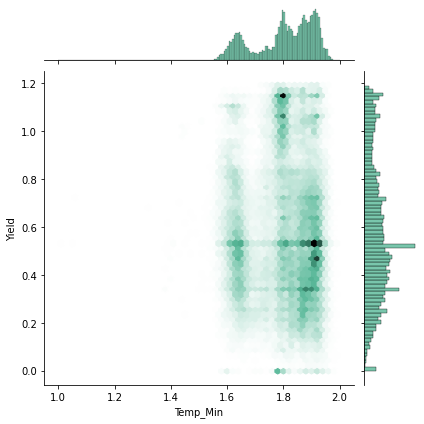

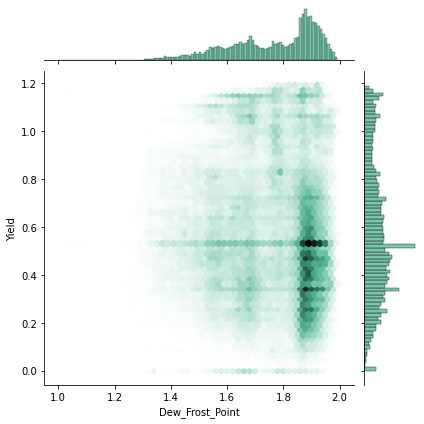

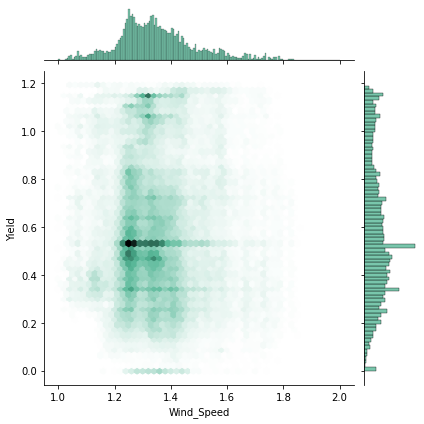

In [34]:
# Yield vs columns
for col in ['GW_depth_Min', 'GW_depth_Max', 'Wells_depth_0_to_2',
       'Wells_depth_2_to_5', 'Wells_depth_5_to_10', 'Wells_depth_10_to_20',
       'Wells_depth_20_to_40', 'Wells_depth_40_and_above', 'Precipitation',
       'Solar_Radiation', 'Surface_Pressure', 'Humidity', 'Temp_Max',
       'Temp_Min', 'Dew_Frost_Point', 'Wind_Speed']:
    sns.jointplot(x=col, y='Yield', data=df, kind="hex", color="#4CB391")
    plt.xlabel(col)
    plt.ylabel('Yield = BoxCox(Yield)')
    plt.show()



boxcox-GW_depth_Min vs. Yield = BoxCox(Yield)


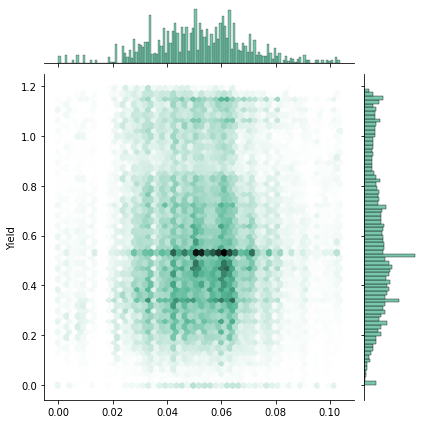



boxcox-GW_depth_Max vs. Yield = BoxCox(Yield)


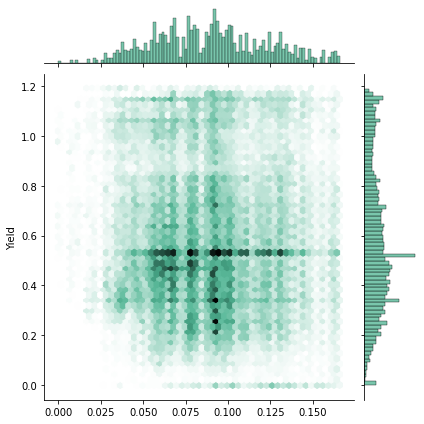



boxcox-Wells_depth_0_to_2 vs. Yield = BoxCox(Yield)


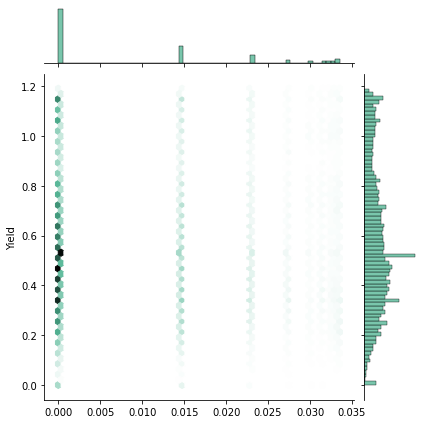



boxcox-Wells_depth_2_to_5 vs. Yield = BoxCox(Yield)


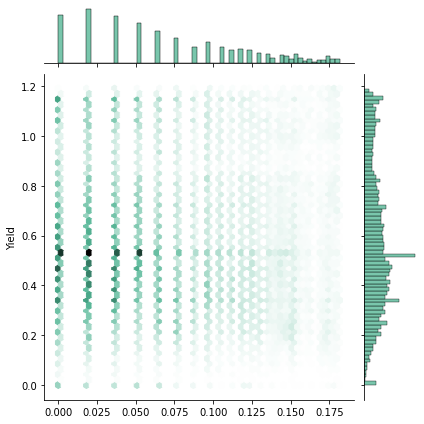



boxcox-Wells_depth_5_to_10 vs. Yield = BoxCox(Yield)


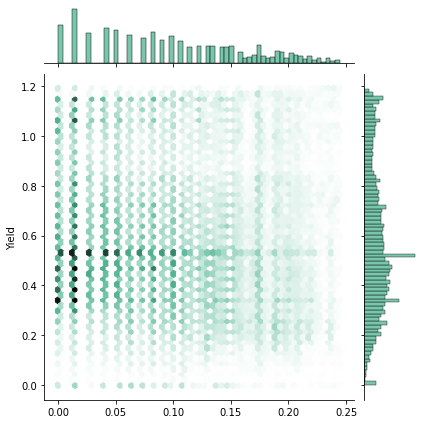



boxcox-Wells_depth_10_to_20 vs. Yield = BoxCox(Yield)


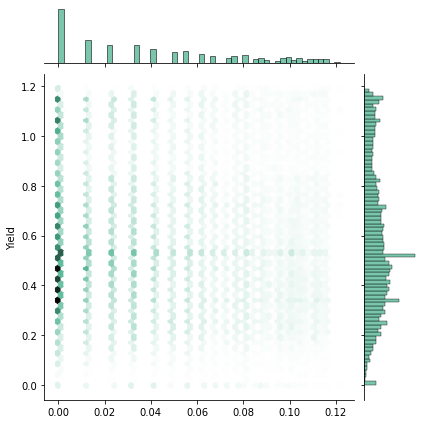



boxcox-Wells_depth_20_to_40 vs. Yield = BoxCox(Yield)


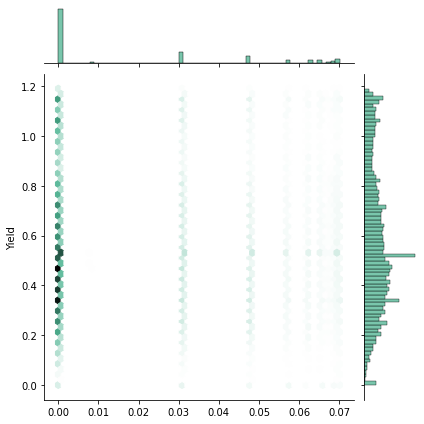



boxcox-Wells_depth_40_and_above vs. Yield = BoxCox(Yield)


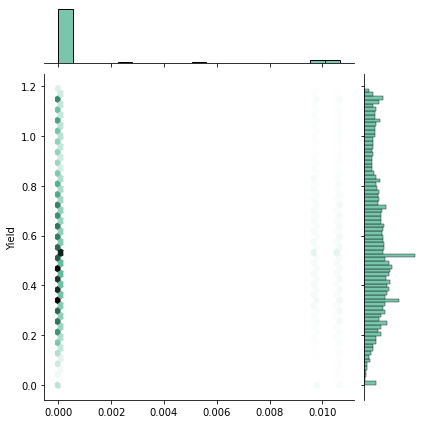



boxcox-Precipitation vs. Yield = BoxCox(Yield)


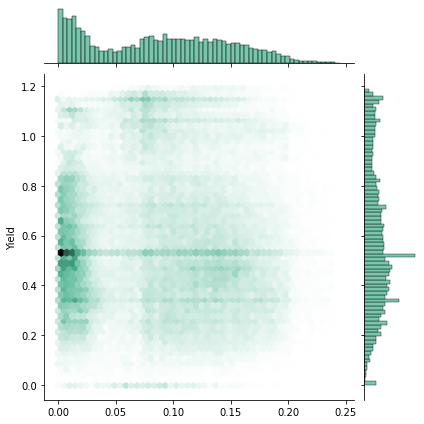



boxcox-Solar_Radiation vs. Yield = BoxCox(Yield)


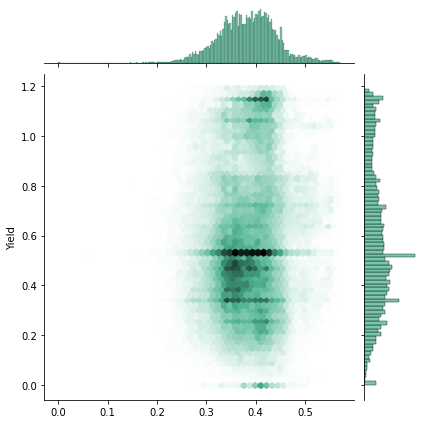



boxcox-Surface_Pressure vs. Yield = BoxCox(Yield)


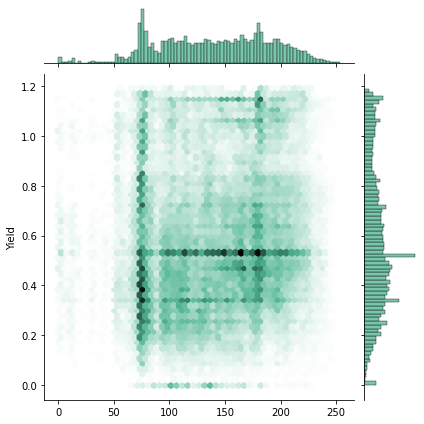



boxcox-Humidity vs. Yield = BoxCox(Yield)


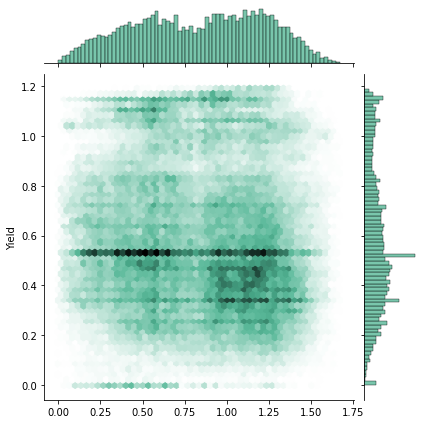



boxcox-Temp_Max vs. Yield = BoxCox(Yield)


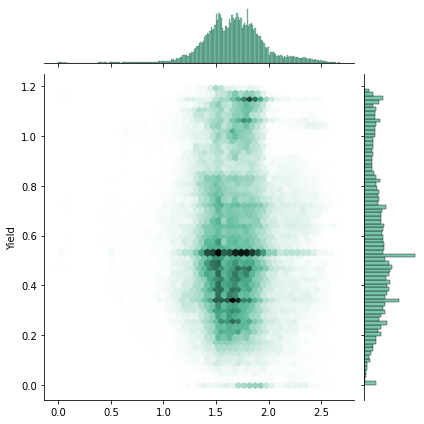



boxcox-Temp_Min vs. Yield = BoxCox(Yield)


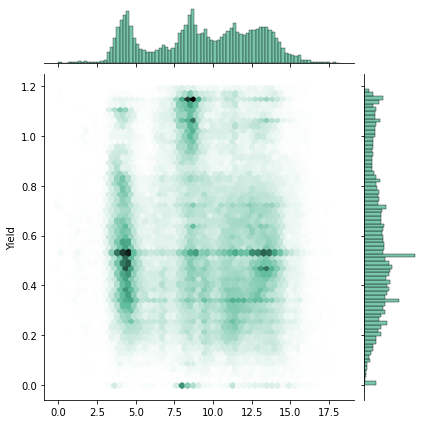



boxcox-Dew_Frost_Point vs. Yield = BoxCox(Yield)


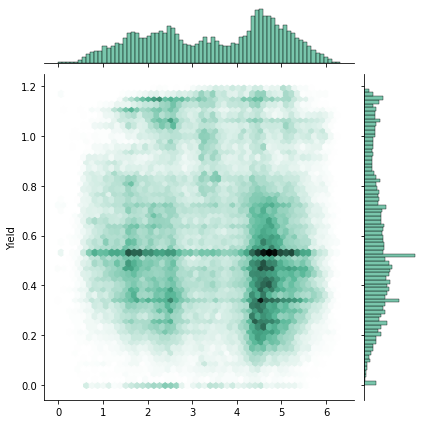



boxcox-Wind_Speed vs. Yield = BoxCox(Yield)


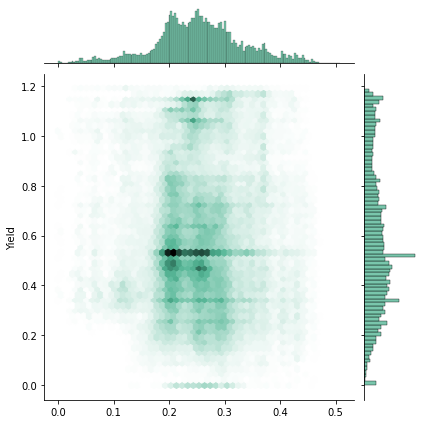

In [35]:
# Yield vs boxcox-columns
for col in ['GW_depth_Min', 'GW_depth_Max', 'Wells_depth_0_to_2',
       'Wells_depth_2_to_5', 'Wells_depth_5_to_10', 'Wells_depth_10_to_20',
       'Wells_depth_20_to_40', 'Wells_depth_40_and_above', 'Precipitation',
       'Solar_Radiation', 'Surface_Pressure', 'Humidity', 'Temp_Max',
       'Temp_Min', 'Dew_Frost_Point', 'Wind_Speed']:
    print(f'\n\nboxcox-{col} vs. Yield = BoxCox(Yield)')
    sns.jointplot(x=boxcox(df[col])[0], y=df['Yield'], kind="hex", color="#4CB391")
    plt.show()

## Correlation

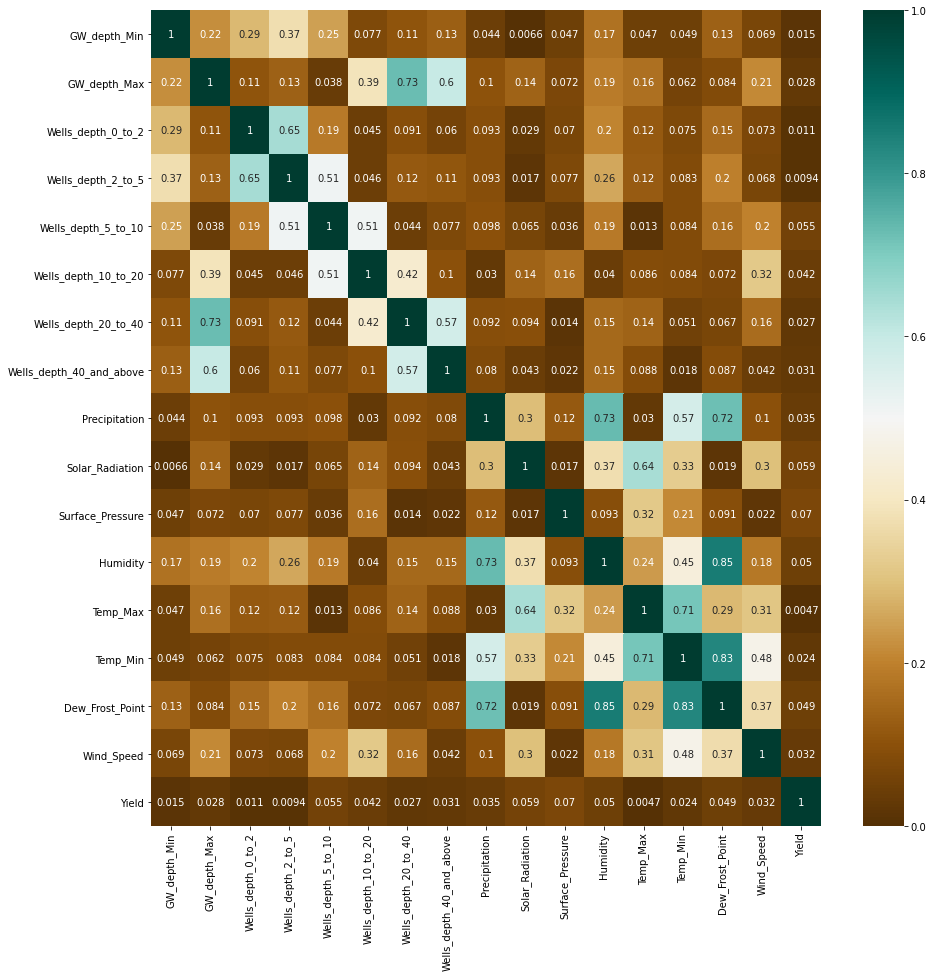

In [36]:
df_for_corr = df.select_dtypes(exclude='object').copy()

plt.figure(figsize=(15,15))
sns.heatmap(df_for_corr.corr().abs(), annot=True, vmin=0, vmax=1, cmap=plt.cm.BrBG)
plt.show()

**Note**

Taking correlation cut-off as 80.

We find following as highly correlated features:
1. Humidity vs. Dew_Frost_Point
2. Temp_Min vs Dew_Frost_Point

**Pipeline Action**

Drop column Dew_Frost_Point due to high correlation (above 80)

In [37]:
# Drop Dew_Frost_Point due to high correlation
df = df.drop('Dew_Frost_Point', axis=1)

print(df.shape)
print(df.columns)

(164552, 20)
Index(['GW_depth_Min', 'GW_depth_Max', 'Wells_depth_0_to_2',
       'Wells_depth_2_to_5', 'Wells_depth_5_to_10', 'Wells_depth_10_to_20',
       'Wells_depth_20_to_40', 'Wells_depth_40_and_above', 'Precipitation',
       'Solar_Radiation', 'Surface_Pressure', 'Humidity', 'Temp_Max',
       'Temp_Min', 'Wind_Speed', 'Season', 'Crop', 'Yield', 'Geo_Region',
       'Crop_Type'],
      dtype='object')


## ANOVA test for Crop, Season and Geo_Region

In [38]:
model = smf.ols('Yield ~ Crop', data = df).fit()
                
anova_result = sm.stats.anova_lm(model, typ=2)
print(anova_result)
print('\n\n')

model = smf.ols('Yield ~ Season', data = df).fit()
                
anova_result = sm.stats.anova_lm(model, typ=2)
print(anova_result)
print('\n\n')

model = smf.ols('Yield ~ Geo_Region', data = df).fit()
                
anova_result = sm.stats.anova_lm(model, typ=2)
print(anova_result)
print('\n\n')

model = smf.ols('Yield ~ Crop + Season', data = df).fit()
                
anova_result = sm.stats.anova_lm(model, typ=2)
print(anova_result)
print('\n\n')

model = smf.ols('Yield ~ Crop + Season + Geo_Region', data = df).fit()
                
anova_result = sm.stats.anova_lm(model, typ=2)
print(anova_result)
print('\n\n')

               sum_sq        df            F  PR(>F)
Crop      9489.855660      82.0  4633.495559     0.0
Residual  4107.911279  164469.0          NaN     NaN



                sum_sq        df            F  PR(>F)
Season     1684.796340       5.0  4654.195968     0.0
Residual  11912.970598  164546.0          NaN     NaN



                  sum_sq        df         F  PR(>F)
Geo_Region    230.540663       5.0  567.5754     0.0
Residual    13367.226275  164546.0       NaN     NaN



               sum_sq        df            F  PR(>F)
Crop      7942.748665      82.0  4012.481402     0.0
Season     137.689346       5.0  1140.739283     0.0
Residual  3970.221933  164464.0          NaN     NaN



                 sum_sq        df            F  PR(>F)
Crop        7849.781344      82.0  4045.106937     0.0
Season       129.356074       5.0  1093.208806     0.0
Geo_Region    78.235253       5.0   661.178599     0.0
Residual    3891.986679  164459.0          NaN     NaN





Above results of ANOVA test shows that Crop, Season and Geo_Region have significant impact on Yield.

# Feature Importance

## Analysis using OLS

In [39]:
def ols_summary(cols, Yield, data):
    formula_str = f"{Yield} ~ "
    for col in cols:
        formula_str += f" + {col}"
    return smf.ols(formula=formula_str, data=data).fit().summary()

In [40]:
ols_summary(['GW_depth_Min', 'GW_depth_Max', 'Wells_depth_0_to_2',
       'Wells_depth_2_to_5', 'Wells_depth_5_to_10', 'Wells_depth_10_to_20',
       'Wells_depth_20_to_40', 'Wells_depth_40_and_above', 'Precipitation',
       'Solar_Radiation', 'Surface_Pressure', 'Humidity', 'Temp_Max',
       'Temp_Min', 'Wind_Speed', 'C(Crop)', 'C(Season)', 'C(Geo_Region)'], 'Yield', df)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Yield   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                     4040.
Date:                Sun, 14 Mar 2021   Prob (F-statistic):               0.00
Time:                        13:23:15   Log-Likelihood:                 77699.
No. Observations:              164552   AIC:                        -1.552e+05
Df Residuals:                  164444   BIC:                        -1.541e+05
Df Model:                         107                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                0.5498      0.049     11.149      0.000       0.453       0.646
C(Crop)[T.Arecanut]                     -0.0219      0.041     -0.540      0.589      -0.102       0.058
C(Crop)[T.Arhar/Tur]                    -0.1775      0.040     -4.390      0.000      -0.257      -0.098
C(Crop)[T.Atcanut (Raw)]                 0.3644      0.055      6.596      0.000       0.256       0.473
C(Crop)[T.Bajra]                        -0.0917      0.040     -2.266      0.023      -0.171      -0.012
C(Crop)[T.Banana]                        0.4682      0.040     11.565      0.000       0.389       0.548
C(Crop)[T.Barley]                       -0.0232      0.040     -0.572      0.567      -0.103       0.056
C(Crop)[T.Beans & Mutter(Vegetable)]    -0.0943      0.043     -2.200      0.028      -0.178      -0.010
C(Crop)[T.Bhindi]                       -0.1629      0.042     -3.880      0.000      -0.245      -0.081
C(Crop)[T.Black pepper]                 -0.1738      0.041     -4.260      0.000      -0.254      -0.094
C(Crop)[T.Blackgram]                    -0.2069      0.046     -4.487      0.000      -0.297      -0.117
C(Crop)[T.Brinjal]                       0.0634      0.041      1.532      0.125      -0.018       0.144
C(Crop)[T.Cabbage]                      -0.1090      0.042     -2.575      0.010      -0.192      -0.026
C(Crop)[T.Cardamom]                     -0.5478      0.041    -13.226      0.000      -0.629      -0.467
C(Crop)[T.Cashewnut]                    -0.3205      0.041     -7.872      0.000      -0.400      -0.241
C(Crop)[T.Cashewnut Processed]          -0.5029      0.054     -9.232      0.000      -0.610      -0.396
C(Crop)[T.Cashewnut Raw]                -0.2824      0.049     -5.747      0.000      -0.379      -0.186
C(Crop)[T.Castor seed]                  -0.2369      0.040     -5.850      0.000      -0.316      -0.158
C(Crop)[T.Citrus Fruit]                 -0.0952      0.042     -2.286      0.022      -0.177      -0.014
C(Crop)[T.Coconut]                       0.4217      0.041     10.397      0.000       0.342       0.501
C(Crop)[T.Coffee]                       -0.2038      0.079     -2.590      0.010      -0.358      -0.050
C(Crop)[T.Colocosia]                     0.4737      0.156      3.031      0.002       0.167       0.780
C(Crop)[T.Coriander]                    -0.2821      0.040     -6.971      0.000      -0.361      -0.203
C(Crop)[T.Cotton(lint)]                 -0.0364      0.040     -0.899      0.369      -0.116       0.043
C(Crop)[T.Cowpea(Lobia)]                -0.3297      0.041     -8.027      0.000      -0.410      -0.249
C(Crop)[T.Drum Stick]                   -0.3983      0.044     -9.136      0.000      -0.484      -0.313
C(Crop)[T.Dry chillies]               

In [41]:
ols_summary(['GW_depth_Min', 'GW_depth_Max', 'Wells_depth_0_to_2',
       'Wells_depth_2_to_5', 'Wells_depth_5_to_10', 'Wells_depth_10_to_20',
       'Wells_depth_20_to_40', 'Wells_depth_40_and_above', 'Precipitation',
       'Solar_Radiation', 'Surface_Pressure', 'Humidity', 'Temp_Max',
       'Temp_Min', 'Wind_Speed', 'C(Crop_Type)', 'C(Geo_Region)'], 'Yield', df)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Yield   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     1191.
Date:                Sun, 14 Mar 2021   Prob (F-statistic):               0.00
Time:                        13:23:17   Log-Likelihood:                -14667.
No. Observations:              164552   AIC:                         2.939e+04
Df Residuals:                  164526   BIC:                         2.965e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.5521      0.047     11.735      0.000       0.460       0.644
C(Crop_Type)[T.C1]           0.2372      0.003     70.011      0.000       0.231       0.244
C(Crop_Type)[T.C2]          -0.0185      0.005     -3.473      0.001      -0.029      -0.008
C(Crop_Type)[T.C3]           0.1415      0.005     26.939      0.000       0.131       0.152
C(Crop_Type)[T.C4]          -0.0208      0.006     -3.608      0.000      -0.032      -0.010
C(Crop_Type)[T.C5]           0.0050      0.005      1.068      0.286      -0.004       0.014
C(Geo_Region)[T.R1]          0.0845      0.003     29.159      0.000       0.079       0.090
C(Geo_Region)[T.R2]          0.0435      0.004     11.052      0.000       0.036       0.051
C(Geo_Region)[T.R3]          0.0431      0.003     17.182      0.000       0.038       0.048
C(Geo_Region)[T.R4]          0.0049      0.003      1.825      0.068      -0.000       0.010
C(Geo_Region)[T.R5]          0.0579      0.003     22.907      0.000       0.053       0.063
GW_depth_Min                 0.0499      0.011      4.593      0.000       0.029       0.071
GW_depth_Max                -0.0196      0.008     -2.353      0.019      -0.036      -0.003
Wells_depth_0_to_2          -0.1666      0.016    -10.634      0.000      -0.197      -0.136
Wells_depth_2_to_5           0.0795      0.007     12.199      0.000       0.067       0.092
Wells_depth_5_to_10         -0.1355      0.006    -23.364      0.000      -0.147      -0.124
Wells_depth_10_to_20         0.0801      0.009      8.751      0.000       0.062       0.098
Wells_depth_20_to_40         0.0856      0.009      9.974      0.000       0.069       0.102
Wells_depth_40_and_above    -0.2211      0.014    -16.030      0.000      -0.248      -0.194
Precipitation                0.1705      0.012     14.006      0.000       0.147       0.194
Solar_Radiation              0.0708      0.011      6.559      0.000       0.050       0.092
Surface_Pressure             0.4207      0.013     31.730      0.000       0.395       0.447
Humidity                    -0.0164      0.010     -1.677      0.093      -0.036       0.003
Temp_Max                    -0.4598      0.033    -14.076      0.000      -0.524      -0.396
Temp_Min                    -0.0583      0.031     -1.909      0.056      -0.118       0.002
Wind_Speed                   0.0193      0.009      2.104      0.035       0.001       0.037
==============================================================================
Omnibus:                     1102.810   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              769.691
Skew:                           0.032   Prob(JB):                    7.31e-168
Kurtosis:                       2.671   Cond. No.                     

### Identify cols which need boxcox transformation

In [42]:
# This function find those columns which show improvement in Adj. R-squared value upon boxcox transformation
def get_boxcox_cols(data, Yield, numerical_cols, categorical_cols=[]):
    cols = [*numerical_cols, *categorical_cols]
    
    # Scale data
#     data[numerical_cols] = preprocessing.minmax_scale(data[numerical_cols], feature_range=(1,2))
    
    max_rsquared_adj = 0
    boxcox_cols = []
    
    # Adj. R-squared without boxcox transformation
    formula_str = f"{Yield} ~ "
    for col in cols:
        formula_str += f" + {col}"
    max_rsquared_adj = smf.ols(formula=formula_str, data=data).fit().rsquared_adj
    
    print(f"Base R2 score = {max_rsquared_adj}")
    
    improvement_log = [max_rsquared_adj]
    
    # Calculate boxcox for each numerical column
    for col in numerical_cols:
        data[f'boxcox_{col}'] = boxcox(data[col])[0]
    
    # Check improvement in Adj. R-squared with boxcox transformation on each column
    for boxcox_col in cols:
        formula_str = f"{Yield} ~ "
        for col in cols:
            if (col not in categorical_cols) and (col == boxcox_col or (col in boxcox_cols)):
                formula_str += f" + boxcox_{col}"
            else:
                formula_str += f" + {col}"
        rsquared_adj = smf.ols(formula=formula_str, data=data).fit().rsquared_adj
        if max_rsquared_adj < rsquared_adj:
            boxcox_cols.append(boxcox_col)
            max_rsquared_adj = rsquared_adj
            improvement_log.append(rsquared_adj)
    return boxcox_cols, improvement_log

In [43]:
# get_boxcox_cols(df.copy(), 'Yield', ['GW_depth_Min', 'GW_depth_Max', 'Wells_depth_0_to_2',
#            'Wells_depth_2_to_5', 'Wells_depth_5_to_10', 'Wells_depth_10_to_20',
#            'Wells_depth_20_to_40', 'Wells_depth_40_and_above', 'Precipitation',
#            'Solar_Radiation', 'Surface_Pressure', 'Humidity', 'Temp_Max',
#            'Temp_Min', 'Wind_Speed'], ['C(Crop)', 'C(Season)', 'C(Geo_Region)'])

No other boxcox transformation is required because the improvement seen using transformed columns is very less.

## Analysis using Decision Tree Regressor

In [44]:
from sklearn.tree import DecisionTreeRegressor

In [45]:
def reg_summary(reg_model, inputs, target, with_split=True):
    X_train = inputs.select_dtypes(exclude='object').copy()
    X_train = pd.concat([X_train, pd.get_dummies(inputs.select_dtypes('object'))], axis=1)
    y_train = target.copy()
    
    if with_split == True:
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=101)
    
    print('X_train.shape: ' + str(X_train.shape))
    
    print(reg_model)

    reg_model.fit(X_train, y_train)
    
    print(f"Train score: {reg_model.score(X_train, y_train)}")
    if with_split == True:
        print(f"Test score: {reg_model.score(X_val, y_val)}")
    
    # reg.feature_importances_
    feature_scores = pd.DataFrame(X_train.columns, columns=['Feature'])
    feature_scores['Score'] = reg_model.feature_importances_
    
    return feature_scores

### Using Crop

In [46]:
reg = DecisionTreeRegressor()

reg_summary(reg, df.drop(['Crop_Type', 'Yield'], axis=1), df['Yield']).sort_values(by='Score')

X_train.shape: (131641, 110)
DecisionTreeRegressor()
Train score: 1.0
Test score: 0.8113333150197386


,Feature,Score
60,Crop_Kapas,0.000000e+00
41,Crop_Coffee,4.486839e-07
64,Crop_Lentil,7.987452e-07
31,Crop_Blackgram,7.528694e-06
42,Crop_Colocosia,1.880280e-05
24,Crop_Atcanut (Raw),2.070806e-05
21,Crop_Arcanut (Processed),3.134374e-05
97,Crop_Tea,4.507969e-05
85,Crop_Rubber,4.593396e-05
102,Crop_Varagu,4.987005e-05


Train vs. Test scores shows that DEcision Tree Regressor is overfitting.

### Using Crop_Type

In [47]:
reg = DecisionTreeRegressor()

reg_summary(reg, df.drop(['Crop', 'Yield'], axis=1), df['Yield']).sort_values(by='Score')

X_train.shape: (131641, 33)
DecisionTreeRegressor()
Train score: 0.3617930845616786
Test score: 0.03675462425846043


,Feature,Score
28,Crop_Type_C1,0.000000
18,Season_Summer,0.000000
29,Crop_Type_C2,0.000049
16,Season_Kharif,0.000132
15,Season_Autumn,0.000171
23,Geo_Region_R2,0.000196
17,Season_Rabi,0.000408
27,Crop_Type_C0,0.000463
31,Crop_Type_C4,0.000948
32,Crop_Type_C5,0.001073


Seems like Crop_Type could not explain much about Yield.

## Analysis using Random Forest Regressor

In [48]:
from sklearn.ensemble import RandomForestRegressor

### Using Crop

In [49]:
reg = RandomForestRegressor(n_estimators=15, n_jobs=-1)

reg_summary(reg, df.drop(['Crop_Type', 'Yield'], axis=1), df['Yield']).sort_values(by='Score')

X_train.shape: (131641, 110)
RandomForestRegressor(n_estimators=15, n_jobs=-1)
Train score: 0.9820134152095317
Test score: 0.8926059365277412


,Feature,Score
60,Crop_Kapas,9.078496e-08
64,Crop_Lentil,5.979486e-07
41,Crop_Coffee,1.823835e-06
31,Crop_Blackgram,6.493560e-06
42,Crop_Colocosia,3.410302e-05
85,Crop_Rubber,3.925940e-05
102,Crop_Varagu,4.271284e-05
24,Crop_Atcanut (Raw),4.392004e-05
21,Crop_Arcanut (Processed),4.704826e-05
97,Crop_Tea,1.097116e-04


Train vs. Test scores shows that Random Forest Regressor is overfitting.

### Using Crop_Type

In [50]:
reg = RandomForestRegressor(n_estimators=15, n_jobs=-1)

reg_summary(reg, df.drop(['Crop', 'Yield'], axis=1), df['Yield']).sort_values(by='Score')

X_train.shape: (131641, 33)
RandomForestRegressor(n_estimators=15, n_jobs=-1)
Train score: 0.3501082614490679
Test score: 0.06308266189833411


,Feature,Score
27,Crop_Type_C0,0.000322
23,Geo_Region_R2,0.000330
15,Season_Autumn,0.000356
17,Season_Rabi,0.000387
16,Season_Kharif,0.000389
31,Crop_Type_C4,0.000456
29,Crop_Type_C2,0.000592
32,Crop_Type_C5,0.000794
20,Season_Winter,0.000858
25,Geo_Region_R4,0.002294


**Observation**

From above results we see that Crop_Type is not explain the variance of Yield. Hence, we must not consider this feature and look for other representation of Crop column.

## Obtain X and y (Checkpoint)

In [51]:
X = df.drop(['Crop_Type', 'Yield'], axis=1)
y = df['Yield']

# Analysis of Crop feature using Categorical Encodings

In [52]:
import category_encoders as ce

## Target Encoding

In [53]:
target_encoder = ce.TargetEncoder()

In [54]:
X['Crop_Encoded'] = target_encoder.fit_transform(df['Crop'], df['Yield'])

/home/animathur/anaconda3/envs/py3-TF2/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [55]:
reg = RandomForestRegressor(n_estimators=15, n_jobs=-1, random_state=101)

reg_summary(reg, X.drop('Crop', axis=1), y)

X_train.shape: (131641, 28)
RandomForestRegressor(n_estimators=15, n_jobs=-1, random_state=101)
Train score: 0.9818689865832494
Test score: 0.8915809131871841


,Feature,Score
0,GW_depth_Min,0.013027
1,GW_depth_Max,0.013378
2,Wells_depth_0_to_2,0.002799
3,Wells_depth_2_to_5,0.009771
4,Wells_depth_5_to_10,0.012851
5,Wells_depth_10_to_20,0.007701
6,Wells_depth_20_to_40,0.005231
7,Wells_depth_40_and_above,0.002231
8,Precipitation,0.016189
9,Solar_Radiation,0.019609


**Observation**

Importance of Crop_Encoded = 0.744395

## Leave One Out Encoding

In [56]:
loo_encoder = ce.LeaveOneOutEncoder()

In [57]:
X['Crop_Encoded'] = loo_encoder.fit_transform(df['Crop'], df['Yield'])

In [58]:
reg = RandomForestRegressor(n_estimators=15, n_jobs=-1, random_state=101)

reg_summary(reg, X.drop('Crop', axis=1), y)

X_train.shape: (131641, 28)
RandomForestRegressor(n_estimators=15, n_jobs=-1, random_state=101)
Train score: 0.9993760743361895
Test score: 0.9968859774055425


,Feature,Score
0,GW_depth_Min,0.000332
1,GW_depth_Max,0.000582
2,Wells_depth_0_to_2,0.000208
3,Wells_depth_2_to_5,0.000595
4,Wells_depth_5_to_10,0.001261
5,Wells_depth_10_to_20,0.000303
6,Wells_depth_20_to_40,0.000600
7,Wells_depth_40_and_above,0.000739
8,Precipitation,0.002947
9,Solar_Radiation,0.001739


**Observation**

1. Importance of Crop_Encoded = 0.942902
2. Seems like target is getting leaked.

## Encode using Weight of Evidence (WoE) for continuous target

In [59]:
woe = crop_woe(df, 'Yield')

Information Value: 16.68486735454739


In [60]:
X['Crop_Encoded'] = X['Crop'].apply(lambda x: woe[x])

In [61]:
reg = RandomForestRegressor(n_estimators=15, n_jobs=-1, random_state=101)

reg_summary(reg, X.drop('Crop', axis=1), y)

X_train.shape: (131641, 28)
RandomForestRegressor(n_estimators=15, n_jobs=-1, random_state=101)
Train score: 0.9819047944402793
Test score: 0.8915546184229549


,Feature,Score
0,GW_depth_Min,0.012828
1,GW_depth_Max,0.013445
2,Wells_depth_0_to_2,0.002829
3,Wells_depth_2_to_5,0.009858
4,Wells_depth_5_to_10,0.012892
5,Wells_depth_10_to_20,0.007529
6,Wells_depth_20_to_40,0.005130
7,Wells_depth_40_and_above,0.002198
8,Precipitation,0.016222
9,Solar_Radiation,0.019512


**Observation**

Importance of Crop_Encoded = 0.743907

**Note**

We see that training, testing and feature importance scores of Random Forest Regressor with same settings for Crop, Crop_Encoded for Target encoding and Crop_Encoded for WoE encoding are very similar.

**Pipeline Action**

We must use Weight of Evidence to encode the Crop column as it considers entire training set of Crops and do not consider direct correlation between Crop and Yield (avoiding target leakage).

# Pipeline for Input Features

We curate all preprocessing steps (Pipeline Actions) to construct a pipeline for input features to the model.